# A machine learning decision tree approach

The iMeta algorithm is essentially a decision tree algorithm, where the variables and threshold for the decisions at each step are manually specified based on human analysis. The simplest way to apply machine learning techniques to the problem would be to use a similar structure to iMeta, which is a decision tree, but use standard ML training techiniques to learn the parameters such as what thresholds to use and how many branches/leaves to have in the tree for the best results. 

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipywidgets
import time

In [3]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
from xbt_dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter

In [6]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}
output_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_output',
    'pangeo': '/data/misc/xbt-data/csv_output/',

}
result_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/results',
    'pangeo': '/data/misc/xbt-data/results/',
}


In [8]:
output_dir = output_dirs[environment]
output_fname_template = 'xbt_output_{classifier}_{suffix}.csv'
result_dir = result_dirs[environment]
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [9]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year']

In [10]:
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_opts = {}
classifier_name = 'decision_tree'
suffix='country'

In [11]:
%%time
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

CPU times: user 1min 44s, sys: 11.2 s, total: 1min 56s
Wall time: 6min 43s


## Data preparation

We are only testing on the labelled data, to be able to evaluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

Our training and evaluation will all happen within the labelled dataset, but ultimately we want to apply the trained ML algorithms to the unlabelled data, as this is where labels are needed to reduce the uncertainty in the ocean temperature dataset. So we need to design our experiment with this in mind. What we need to know is how well does our chosen algorithm generalise to unseen data. 

So within the labelled dataset we split the data into three groups. Firstly, we set a side some fraction of cruises and all profiles that are from those cruises into a group called "unseen". These profiles will not be used in the training or initial evaluation. These will represent cruises that have no labelled data. 

The remainder of the data will then be split into 2 groups, training and test as is standard for a machine learning pipeline. In splitting the data, we will sample a certain fraction of the profiles for train and the rest will be test. But we don't sample from the whole dataset randomly, as this might result in imbalances in representations of years and instrment types. Rather, for each combination of year and instrument label, sample the required fraction from all profiles matching those values. Doing this all possisble value combination of those 2 parameters should results in all years and instrument type being as well represented as possible in both the test and train sets.

So the algorithm will be fit to the training set. Then we will evaulate performance on the test set. This gives us an idea of how the algorithm will perform on unlabelled profiles where other profiles from the same cruise are labelled. Then we will evaluate performance of the algorithm on the unseen dataset. This suggests how the algorithm will perform on unlabelled profiles where no profiles from that cruise are labelled. Both of these sorts of profiles have been found to be present in the unlabelled data, so it is important to evaluate the algorithm for both cases.

In [12]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 328 ms, sys: 340 ms, total: 668 ms
Wall time: 30.8 s


The format of the data in the pandas dataframe is not suitable for feeding into the machine learning algorithms. We have to appropriately encode the data for training. The dataset class has knowledge of the different types of data represented and how each type should be encoded. This happens through the get_ml_dataset method. Calling this with the return_data flag as False doesn't actually encode the data, but initialises the encoder objects required. These encoders are then used for subsequent encoding operations, so encoding are consistent for the whole experiment and results can be compared.

In [13]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [14]:
%%time
unseen_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)

CPU times: user 33.4 ms, sys: 139 µs, total: 33.5 ms
Wall time: 32.4 ms


In [15]:
%%time
xbt_unseen = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_working = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

CPU times: user 7.55 s, sys: 0 ns, total: 7.55 s
Wall time: 7.55 s


In [16]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [17]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are initially also interested in investigating classifier performance looking at prove model and manufacturer separately, as well as looking at the combined model and manufacturer info as a single label and using that as the target feature.

In [19]:
%%time
xbt_train_all, xbt_test_all = xbt_working.train_test_split(refresh=True, features=['instrument', 'year'])

CPU times: user 3min 1s, sys: 36.3 ms, total: 3min 1s
Wall time: 3min 1s


In [20]:
X_train_all = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_unseen_all = xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]
y_model_train_all = xbt_train_all.filter_features(['model']).get_ml_dataset()[0]
y_manuf_train_all = xbt_train_all.filter_features(['manufacturer']).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features(['instrument']).get_ml_dataset()[0]
y_model_test_all = xbt_test_all.filter_features(['model']).get_ml_dataset()[0]
y_manuf_test_all = xbt_test_all.filter_features(['manufacturer']).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features(['instrument']).get_ml_dataset()[0]
y_model_unseen_all = xbt_unseen.filter_features(['model']).get_ml_dataset()[0]
y_manuf_unseen_all = xbt_unseen.filter_features(['manufacturer']).get_ml_dataset()[0]
y_instr_unseen_all = xbt_unseen.filter_features(['instrument']).get_ml_dataset()[0]

## Training the classifier

We are using the scikit-learn Decision Tree classifier as the closest analogue to the structure of the iMeta algorithm. This tree can have many more nodes and leaves than iMeta though. it is quick to train and evaluate so it is a useful starting point for setting up the ML processing pipelines, as all the scikit-learn classifiers have a common interface. 

For each of the target variables (probe model, probe manufacturer, combined probe model/manufacteer label), we train a Decision Tree classifier, then use it to predict values for the train and test sets. We then calculate the accuracy metrics for each for the whole dataset. 

I am using precision, recall and F1 as fairly standard ML metrics of accuracy. Recall is what has been used in the two previous papers (Palmer et. al, Leahy and Llopis et al) so that is the focus. Support is a useful to see what proportion of the profiles in the dataset belong to each of the different classes.

Documentation
* https://scikit-learn.org/stable/modules/tree.html
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [21]:
metrics_per_class_all = {}
metrics_avg_all = {}

In [22]:
clf_dt_model1 = classifier_class(**classifier_opts)
clf_dt_model1.fit(X_train_all,y_model_train_all)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [23]:
y_res_train_model_all = clf_dt_model1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_model_train_all, y_res_train_model_all, )
metrics_per_class_all.update( {
    'precision_model_train': metrics1[0],
    'recall_model_train': metrics1[1],
    'f1_model_train': metrics1[2],
    'support_model_train': metrics1[3],
})

metrics_avg_all.update({
    'precision_model_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_model_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_model_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [24]:
y_res_test_model = clf_dt_model1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_model_test_all, y_res_test_model,)
metrics_per_class_all.update( {
    'precision_model_test': metrics1[0],
    'recall_model_test': metrics1[1],
    'f1_model_test': metrics1[2],
    'support_model_test': metrics1[3],
})

metrics_avg_all.update({
    'precision_model_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_model_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_model_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [25]:
y_res_unseen_model = clf_dt_model1.predict(X_unseen_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_model_unseen_all, y_res_unseen_model,)
metrics_per_class_all.update( {
    'precision_model_unseen': metrics1[0],
    'recall_model_unseen': metrics1[1],
    'f1_model_unseen': metrics1[2],
    'support_model_unseen': metrics1[3],
})

metrics_avg_all.update({
    'precision_model_unseen' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_model_unseen' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_model_unseen' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [26]:
clf_dt_manuf1 = classifier_class(**classifier_opts)
clf_dt_manuf1.fit(X_train_all,y_manuf_train_all)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [27]:
y_res_train_manuf_all = clf_dt_manuf1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_manuf_train_all, y_res_train_manuf_all, )
metrics_per_class_all.update( {
    'precision_manuf_train': metrics1[0],
    'recall_manuf_train': metrics1[1],
    'f1_manuf_train': metrics1[2],
    'support_manuf_train': metrics1[3],
})

metrics_avg_all.update({
    'precision_manuf_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_manuf_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_manuf_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})



In [28]:
y_res_test_manuf_all = clf_dt_manuf1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_manuf_test_all, y_res_test_manuf_all, )
metrics_per_class_all.update( {
    'precision_manuf_test': metrics1[0],
    'recall_manuf_test': metrics1[1],
    'f1_manuf_test': metrics1[2],
    'support_manuf_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_manuf_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_manuf_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_manuf_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})


In [29]:
y_res_unseen_manuf_all = clf_dt_manuf1.predict(X_unseen_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_manuf_unseen_all, y_res_unseen_manuf_all, )
metrics_per_class_all.update( {
    'precision_manuf_unseen': metrics1[0],
    'recall_manuf_unseen': metrics1[1],
    'f1_manuf_unseen': metrics1[2],
    'support_manuf_unseen': metrics1[3],
})
metrics_avg_all.update({
    'precision_manuf_unseen' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_manuf_unseen' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_manuf_unseen' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [30]:
clf_dt_instr1 = classifier_class(**classifier_opts)
clf_dt_instr1.fit(X_train_all,y_instr_train_all)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [31]:
y_res_train_instr_all = clf_dt_instr1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_train_all, y_res_train_instr_all, )
metrics_per_class_all.update( {
    'precision_instr_train': metrics1[0],
    'recall_instr_train': metrics1[1],
    'f1_instr_train': metrics1[2],
    'support_instr_train': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [32]:
y_res_test_instr_all = clf_dt_instr1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_test_all, y_res_test_instr_all, )
metrics_per_class_all.update( {
    'precision_instr_test': metrics1[0],
    'recall_instr_test': metrics1[1],
    'f1_instr_test': metrics1[2],
    'support_instr_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [33]:
y_res_unseen_instr_all = clf_dt_instr1.predict(X_unseen_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_unseen_all, y_res_unseen_instr_all, )
metrics_per_class_all.update( {
    'precision_instr_unseen': metrics1[0],
    'recall_instr_unseen': metrics1[1],
    'f1_instr_unseen': metrics1[2],
    'support_instr_unseen': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_unseen' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_unseen' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_unseen' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [34]:
metrics_per_class_all['model'] = list(xbt_labelled._feature_encoders['model'].categories_[0])
metrics_per_class_all['manufacturer'] = list(xbt_labelled._feature_encoders['manufacturer'].categories_[0])
metrics_per_class_all['instrument'] = list(xbt_labelled._feature_encoders['instrument'].categories_[0])

In [35]:
df_metrics_per_class_model = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'model' in k1})
df_metrics_per_class_manuf = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'manuf' in k1})
df_metrics_per_class_instr = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'instr' in k1})

In [36]:
df_metrics_avg = pandas.DataFrame.from_dict({
    'target': ['model_train','model_test', 'model_unseen', 'manufacturer_train','manufacturer_test', 'manufacturer_unseen','instrument_train','instrument_test', 'instrument_unseen'],
    'precision': [v1 for k1,v1 in metrics_avg_all.items() if 'precision' in k1],
    'recall': [v1 for k1,v1 in metrics_avg_all.items() if 'recall' in k1],
    'f1': [v1 for k1,v1 in metrics_avg_all.items() if 'f1' in k1],
})

In [37]:
df_metrics_avg

,target,precision,recall,f1
0,model_train,0.998436,0.996509,0.997469
1,model_test,0.932970,0.931513,0.932224
2,model_unseen,0.907634,0.907047,0.907127
3,manufacturer_train,0.999990,0.999878,0.999934
4,manufacturer_test,0.994029,0.993938,0.993983
5,manufacturer_unseen,0.988745,0.988910,0.988806
6,instrument_train,0.998436,0.996473,0.997450
7,instrument_test,0.931644,0.930192,0.930899
8,instrument_unseen,0.903982,0.903470,0.903273


# Classification result plots

The plots below show the results for the whole XBT dataset. We see that the DT classifier performs almost perfectly on the training data, but performance degrades for the test data, and further still for the profiles from unseen cruises. So it does not seem to generalise that well, but results are still better than other algorithms where the train and test results are closer together. Performance is poor for classes with very little support in the training dataset, as one might expect.

In [38]:
df_metrics_per_class_model

,precision_model_train,recall_model_train,f1_model_train,support_model_train,precision_model_test,recall_model_test,f1_model_test,support_model_test,precision_model_unseen,recall_model_unseen,f1_model_unseen,support_model_unseen,model
0,1.000000,1.000000,1.000000,77,0.785714,0.550000,0.647059,20,0.666667,0.500000,0.571429,8,AXBT
1,1.000000,1.000000,1.000000,483,0.467742,0.479339,0.473469,121,0.275862,0.181818,0.219178,44,AXBT 536
2,0.996001,0.996718,0.996360,251391,0.958869,0.958502,0.958685,62847,0.938259,0.944151,0.941196,33286,DEEP BLUE
3,1.000000,0.999737,0.999868,3798,0.878981,0.872497,0.875727,949,0.658482,0.847701,0.741206,348,FAST DEEP
4,1.000000,1.000000,1.000000,15,0.333333,0.250000,0.285714,4,0.000000,0.000000,0.000000,0,SUBMARINE-LAUNCHED EXPENDABLE BATHYTHERMOGRAPH
5,0.999936,0.998109,0.999022,31200,0.781733,0.790748,0.786215,7804,0.766443,0.741439,0.753734,4935,T10
6,1.000000,0.987212,0.993565,391,0.264368,0.232323,0.247312,99,0.153846,0.228571,0.183908,35,T11
7,0.999970,0.999423,0.999696,330933,0.960915,0.959869,0.960392,82730,0.940940,0.951245,0.946065,47298,T4
8,1.000000,0.999227,0.999613,12933,0.815187,0.803588,0.809346,3233,0.735774,0.722897,0.729279,2057,T5
9,0.999887,0.997911,0.998898,17708,0.896265,0.898894,0.897577,4431,0.882059,0.875177,0.878604,2820,T6


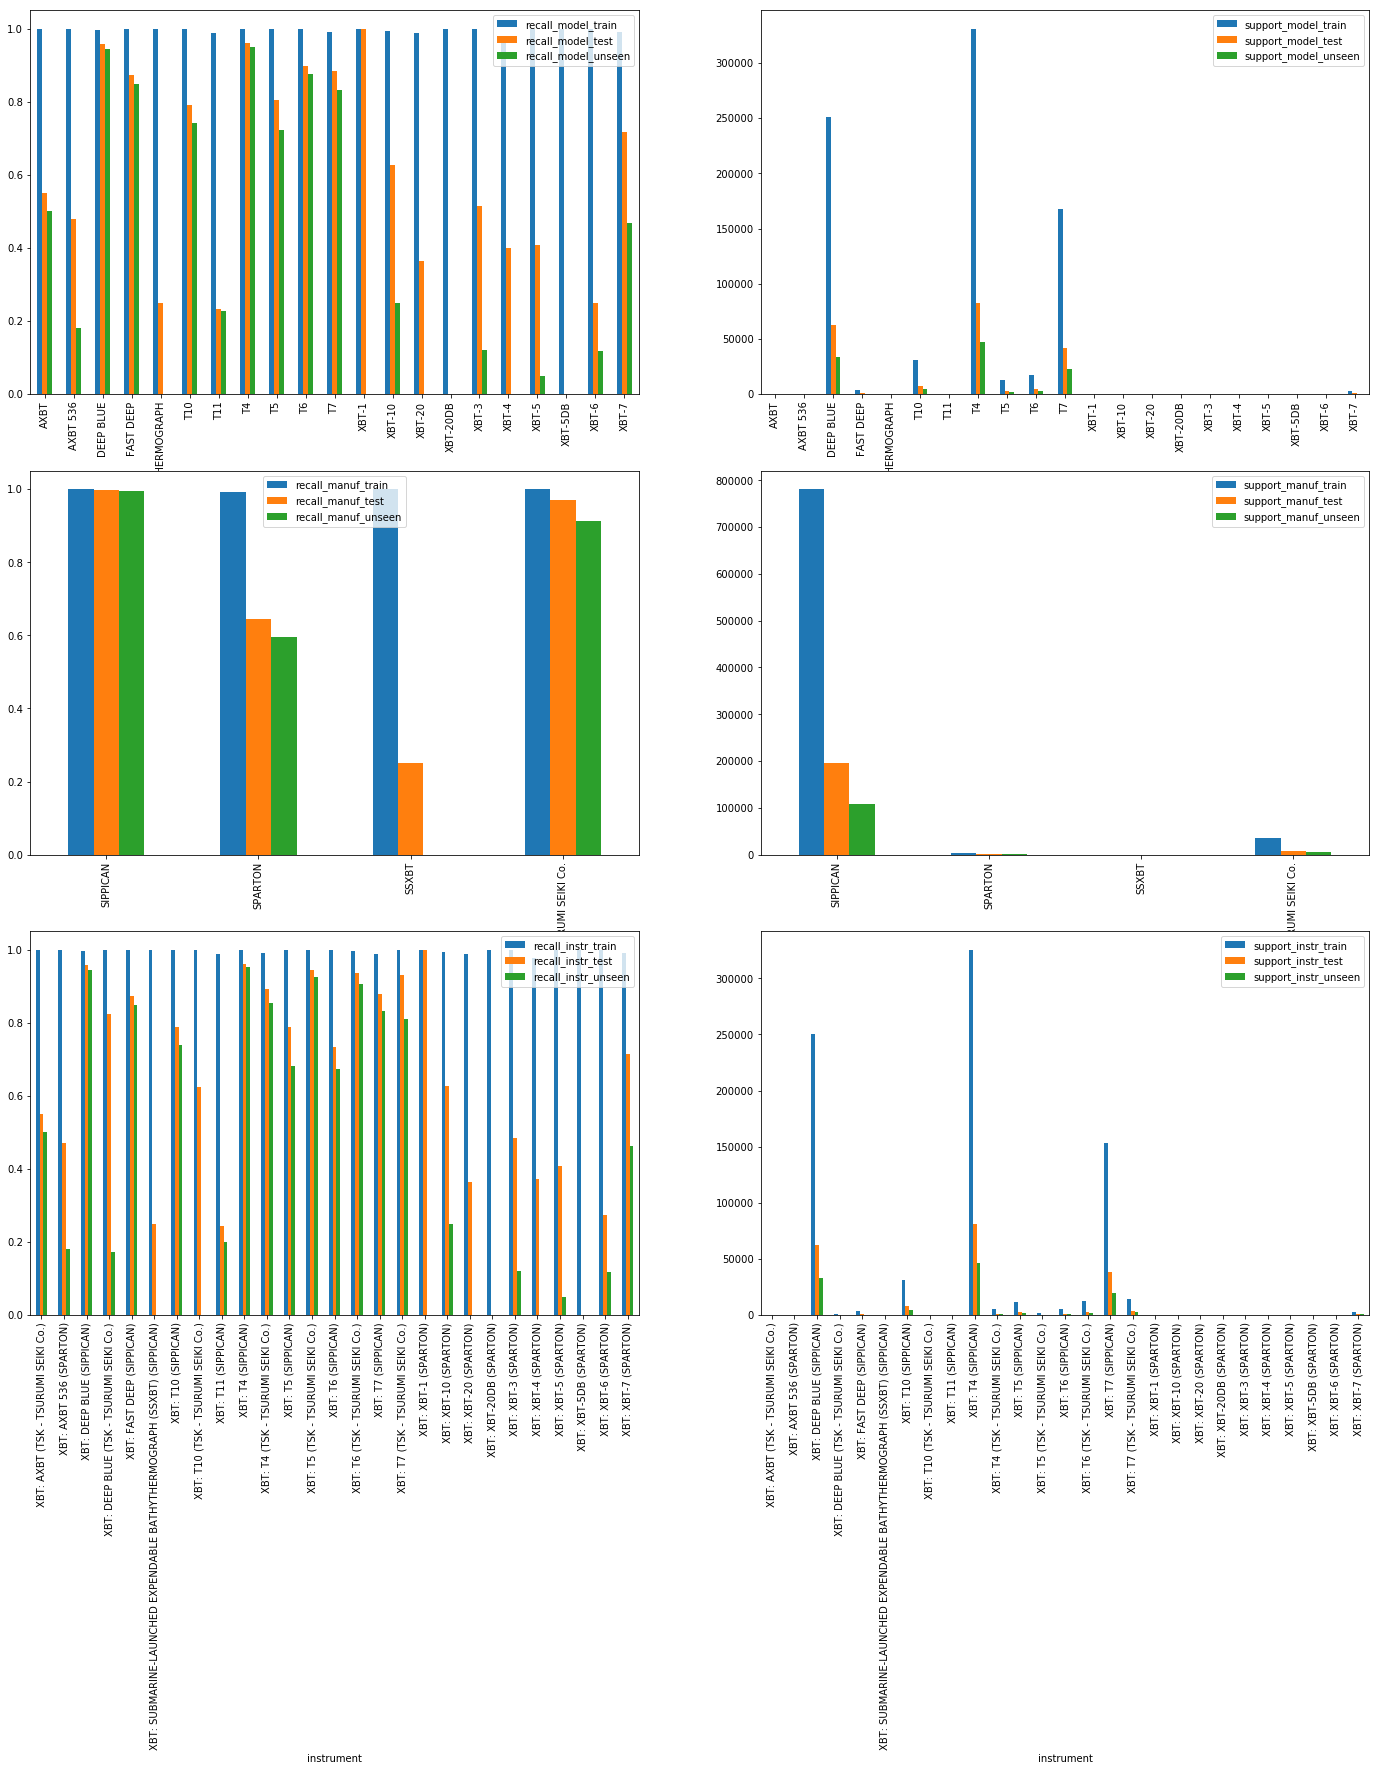

In [39]:
fig_results_all_dt = matplotlib.pyplot.figure('xbt_results_all_dt', figsize=(24,24))
axis_model_metrics = fig_results_all_dt.add_subplot(321)
_ = df_metrics_per_class_model.plot.bar(x='model',y=['recall_model_train', 'recall_model_test', 'recall_model_unseen'], ax=axis_model_metrics)
axis_model_support = fig_results_all_dt.add_subplot(322)
_ = df_metrics_per_class_model.plot.bar(x='model',y=['support_model_train', 'support_model_test', 'support_model_unseen'], ax=axis_model_support)
axis_manuf_metrics = fig_results_all_dt.add_subplot(323)
_ = df_metrics_per_class_manuf.plot.bar(x='manufacturer', y=['recall_manuf_train','recall_manuf_test','recall_manuf_unseen'],ax=axis_manuf_metrics)
axis_manuf_support = fig_results_all_dt.add_subplot(324)
_ = df_metrics_per_class_manuf.plot.bar(x='manufacturer',y=['support_manuf_train', 'support_manuf_test', 'support_manuf_unseen'], ax=axis_manuf_support)
axis_instr_metrics = fig_results_all_dt.add_subplot(325)
_ = df_metrics_per_class_instr.plot.bar(x='instrument', y=['recall_instr_train','recall_instr_test','recall_instr_unseen'],ax=axis_instr_metrics)
axis_instr_support = fig_results_all_dt.add_subplot(326)
_ = df_metrics_per_class_instr.plot.bar(x='instrument',y=['support_instr_train', 'support_instr_test', 'support_instr_unseen'], ax=axis_instr_support)


The plot of performance per class show that results generalise best where there are a substantial number of profiles of that probe type in the training and test sets. Further work may be needed to consider how to boost the performance of underepresented classes. Although these may be only a small number of profiles, we should also consider whether the measurements they contribute are in under represented areas and thus may have a disproportionately alrge impact on the final teprature values in some parts of the world in some years.

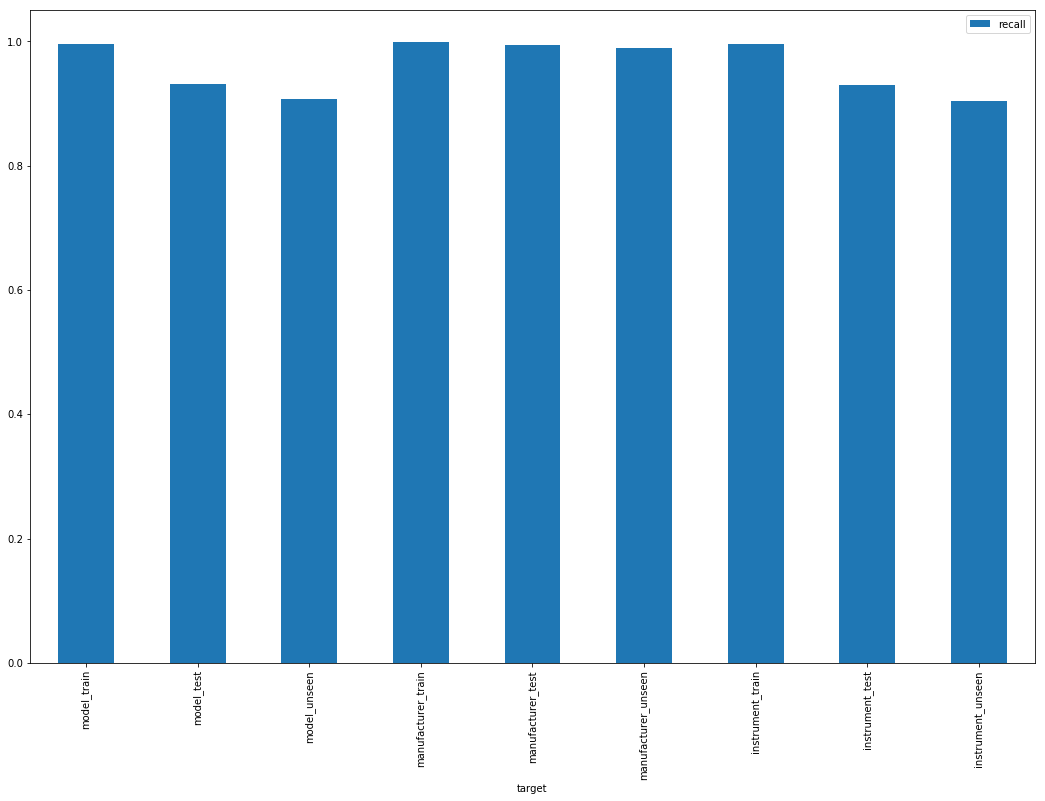

In [40]:
df_metrics_avg.plot.bar(figsize=(18,12), x='target', y='recall')

## Classification results

The contents of the XBT dataset varies over the time period, so previous papers have looked at classification accuracy (recall) year by year to evaluate how performance varies with different distribution of probe types.

To do this we apply the classifier to the train, test  and unseen profile groups for each year separately. For each year we calculate the target metrics for each taret variable and plot the results. We compare the results to those achieved by the iMeta algorithm.

In [41]:
def score_year(xbt_df, year, clf, input_features, target_feature):
    X_year = xbt_df.filter_obs({'year': year}, ).filter_features(input_features).get_ml_dataset()[0]
    y_year = xbt_df.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
    y_res_year = clf.predict(X_year)
    metric_year = sklearn.metrics.precision_recall_fscore_support(
        y_year, y_res_year, average='micro')
    return metric_year

In [42]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [43]:
results_by_year = {}

In [44]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    results_by_year[year] = {
        'metric_train_model' : score_year(xbt_train_all, year, clf_dt_model1, input_feature_names, 'model'),
        'metric_test_model' : score_year(xbt_test_all, year, clf_dt_model1, input_feature_names, 'model'),
        'metric_unseen_model' : score_year(xbt_unseen, year, clf_dt_model1, input_feature_names, 'model'),
        'metric_train_manuf' : score_year(xbt_train_all, year, clf_dt_manuf1, input_feature_names, 'manufacturer'),
        'metric_test_manuf' : score_year(xbt_test_all, year, clf_dt_manuf1, input_feature_names, 'manufacturer'),
        'metric_unseen_manuf' : score_year(xbt_unseen, year, clf_dt_manuf1, input_feature_names, 'manufacturer'),
        'metric_train_instr' : score_year(xbt_train_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_test_instr' : score_year(xbt_test_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_unseen_instr' : score_year(xbt_unseen, year, clf_dt_instr1, input_feature_names, 'instrument'),
    }
    eval_progress.value = year


In [45]:
recall_by_year = pandas.DataFrame.from_dict({ 
    'year':  list(results_by_year.keys()),
    'recall_train_model' : [m1['metric_train_model'][1] for y1,m1 in results_by_year.items()],
    'recall_test_model' : [m1['metric_test_model'][1] for y1,m1 in results_by_year.items()],
    'recall_unseen_model' : [m1['metric_unseen_model'][1] for y1,m1 in results_by_year.items()],
    'recall_train_manuf' : [m1['metric_train_manuf'][1] for y1,m1 in results_by_year.items()],
    'recall_test_manuf' : [m1['metric_test_manuf'][1] for y1,m1 in results_by_year.items()],
    'recall_unseen_manuf' : [m1['metric_unseen_manuf'][1] for y1,m1 in results_by_year.items()],
    'recall_train_instr' : [m1['metric_train_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_test_instr' : [m1['metric_test_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_unseen_instr' : [m1['metric_unseen_instr'][1] for y1,m1 in results_by_year.items()],
})


In [46]:
model_encoder = xbt_labelled._feature_encoders['model']
manuf_encoder = xbt_labelled._feature_encoders['manufacturer']
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [47]:
eval_progress.value = env_date_ranges[environment][0]
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_model = model_encoder.transform(pandas.DataFrame(imeta_model[xbt_labelled.xbt_df.year == year]))
    xbt_model1 = model_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].model))

    y_imeta_manuf = manuf_encoder.transform(pandas.DataFrame(imeta_manufacturer[xbt_labelled.xbt_df.year == year]))
    xbt_manufacturer1 = manuf_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].manufacturer))

    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    
    
    (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = sklearn.metrics.precision_recall_fscore_support(xbt_model1, y_imeta_model,average='micro')
    (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = sklearn.metrics.precision_recall_fscore_support(xbt_manufacturer1, y_imeta_manuf,average='micro')
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='micro')

    imeta_results += [{'year': year,
                       'imeta_model_recall': im_rec_model,
                       'imeta_model_precision': im_pr_model,
                       'imeta_manuf_recall': im_rec_manuf,
                       'imeta_manuf_precision': im_pr_manuf,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                      }]
    eval_progress.value = year

In [48]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [49]:
results_df = pandas.merge(recall_by_year, imeta_res_df).merge(
    pandas.DataFrame.from_dict({
        'year': xbt_labelled['year'].value_counts(sort=False).index,
        'num_samples': xbt_labelled['year'].value_counts(sort=False).values,
    }))

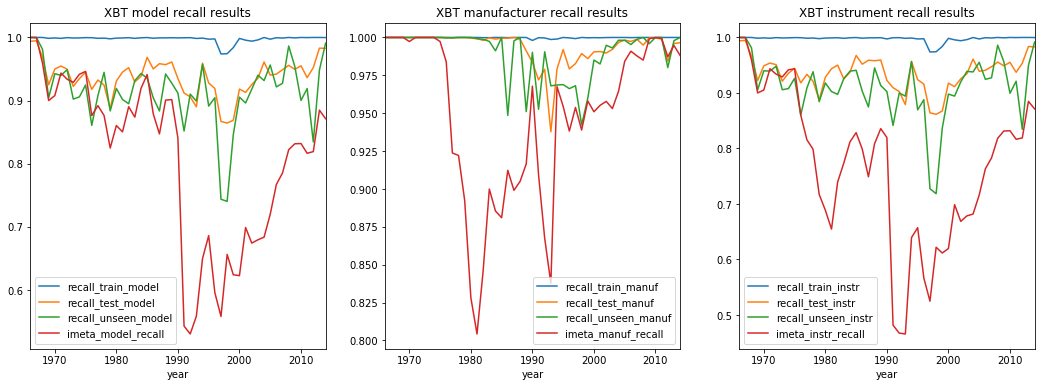

In [50]:
fig_model_recall_results = matplotlib.pyplot.figure('xbt_model_recall', figsize=(18,6))
ax_model_recall_results = fig_model_recall_results.add_subplot(131, title='XBT model recall results')
_ = results_df.plot.line(x='year',y=['recall_train_model','recall_test_model', 'recall_unseen_model', 'imeta_model_recall'], ax=ax_model_recall_results)
ax_manuf_recall_results = fig_model_recall_results.add_subplot(132, title='XBT manufacturer recall results')
_ = results_df.plot.line(x='year',y=['recall_train_manuf','recall_test_manuf', 'recall_unseen_manuf', 'imeta_manuf_recall'], ax=ax_manuf_recall_results)
ax_instr_recall_results = fig_model_recall_results.add_subplot(133, title='XBT instrument recall results')
_ = results_df.plot.line(x='year',y=['recall_train_instr','recall_test_instr', 'recall_unseen_instr', 'imeta_instr_recall'], ax=ax_instr_recall_results)

We see that for both the test and unseen profiles, the decision tree performs at least as well as the iMeta algorithm, and substantially better for some years, particularly the 1985-1995 era when there are a lot of profiles and a lot of them are missing probe type meta data. We can see how the algorithm genalises better in some years that others. The performance on the unseen profiles is slightly worse than the test profiles, but roughly comparable except in a few years where performance is substantially worse. This merits further investigation.

In [51]:
results_df['improvement_model'] = results_df.apply(lambda r1: ((r1['recall_test_model'] /  r1['imeta_model_recall'])-1)*100.0 , axis=1)
results_df['improvement_manuf'] = results_df.apply(lambda r1: ((r1['recall_test_manuf'] /  r1['imeta_manuf_recall'])-1)*100.0 , axis=1)
results_df['improvement_instr'] = results_df.apply(lambda r1: ((r1['recall_test_instr'] /  r1['imeta_instr_recall'])-1)*100.0 , axis=1)

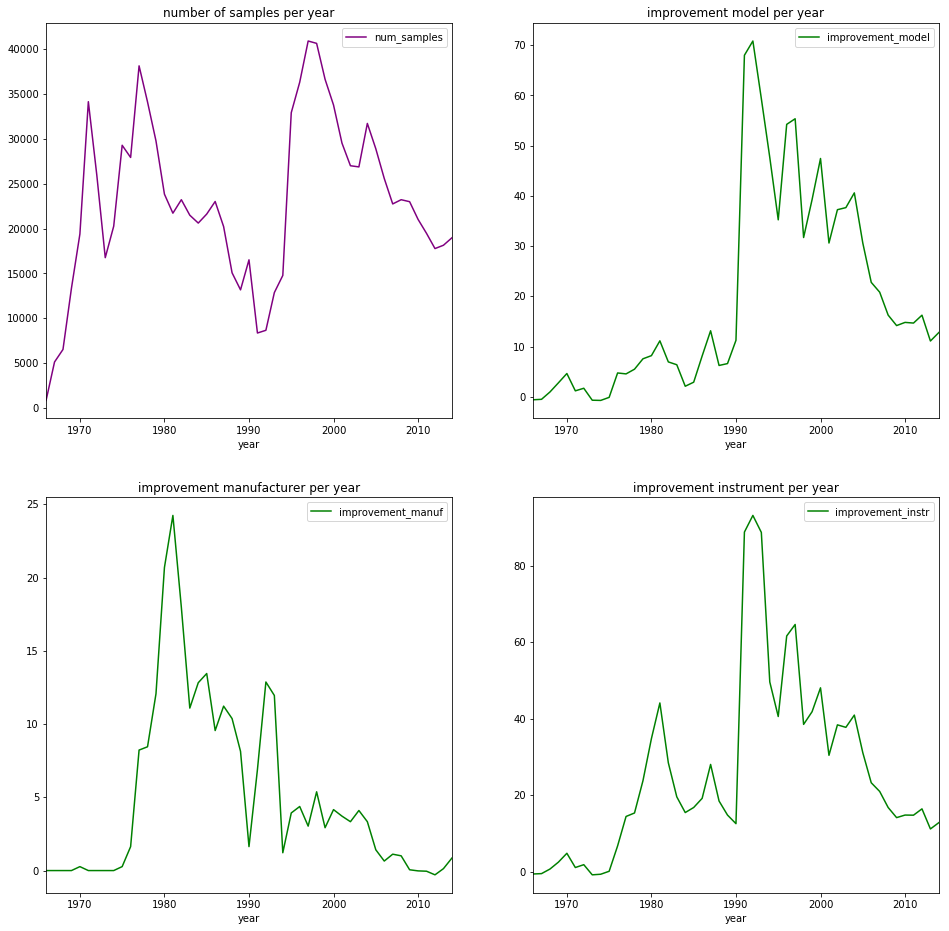

In [52]:
fig_num_samples_per_year = matplotlib.pyplot.figure('fig_num_samples_per_year', figsize=(16,16))
ax_num_samples = fig_num_samples_per_year.add_subplot(221, title='number of samples per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['num_samples'],c='purple' )
ax_num_samples = fig_num_samples_per_year.add_subplot(222, title='improvement model per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_model'], c='green' )
ax_num_samples = fig_num_samples_per_year.add_subplot(223, title='improvement manufacturer per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_manuf'], c='green' )
ax_num_samples = fig_num_samples_per_year.add_subplot(224, title='improvement instrument per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_instr'], c='green' )


We see substantial improvements in recall some years, particularly the early 1990s. This is a postive outcome as this where the high percent of unlabelled data is found.

In [53]:
results_df.to_csv(os.path.join(result_dir,result_fname_template.format(classifier=classifier_name,
                                                                       suffix=suffix)))

### Outputing the data

The output format of the probe classifications is both as a string label, as as a one hot encoding (OHE). OHE econdes the results as as nxm array with each of n rows representing a profile and each of m columns a profile type, with zeroes in most entries except a 1 in the column of the probe type for that profile. This is used as it can be genealised to providing probabilities, where instead of just ones and zeroes, each column represents the probability of the profile being from a particular probe type, with values between 0 and 1 that sum to 1 for each row. This will be explored further in subsequent notebooks.



In [54]:
# checker functions check each element of the profile metadata that could be a problem. The checkers are constructed from the labelled data subset.
checkers_labelled = {f1: c1 for f1, c1 in xbt_labelled.get_checkers().items() if f1 in input_feature_names}

In [55]:
result_feature_name = 'instrument_res_dt'

To filter based on what profiles we can use for predicting, we need some way of checking each profile we create these checkers from the labelled dataset, because the subset of data that was used for training determines what subset is valid for prediction. For example, if a country is not present in the training data, then the prediction function won't be able to handle that profile to predict a probe model and manufacturer. Profiles that are not handled by the trained classifier will get the label "UNKNOWN".


In [56]:
xbt_predictable = xbt_full_dataset.filter_predictable(checkers_labelled)

In [57]:
res_ml1 = clf_dt_instr1.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
res2 = list(xbt_labelled._feature_encoders['instrument'].inverse_transform(res_ml1).reshape(-1))

In [58]:
xbt_predictable.xbt_df[result_feature_name] = res2

In [59]:
xbt_full_dataset.merge_features(xbt_predictable, [result_feature_name],
                               fill_values = {result_feature_name: UNKNOWN_STR},
                               encoders={result_feature_name: xbt_labelled._feature_encoders['instrument']},
                               output_formatters={result_feature_name: cat_output_formatter})

In [60]:
xbt_full_dataset.output_data(os.path.join(output_dir, output_fname_template.format(classifier=classifier_name,
                                                                                  suffix=suffix)),
                             add_ml_features=[result_feature_name])

## Summary
We can see so far that the basic tree approach seems to be outperforming iMeta. Further work needs to be done to calculate these results more rigorously  using cross validation. 

The next step is to explore more sophisticated tree based approaches, such an ensemble of trees (random forest) and gredient-bossted tress (XGBoost),the current state of the art in tree methods. We also need to consider other classification appraches such as neural networks, which have already been applied to this dataset in a previous paper, or a nearest neighbour approach.